<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_23).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**




**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
* Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Pm 10)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Pm10']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380 entries, 3504 to 7883
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   4380 non-null   int64  
 1   Trimestre             4380 non-null   int64  
 2   Mes                   4380 non-null   int64  
 3   Codi_Districte        4380 non-null   int64  
 4   Nom_Districte         4380 non-null   object 
 5   Codi_Barri            4380 non-null   int64  
 6   Nom_Barri             4380 non-null   object 
 7   Compraventa_Unitario  4380 non-null   float64
 8   Pm10                  4380 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 342.2+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Pm10
Fecha,,,,,,,,,
2018-01-01,2018,1,1,1,Ciutat Vella,1,el Raval,3534.3,2.018359
2018-02-01,2018,1,2,1,Ciutat Vella,1,el Raval,3534.3,2.018359
2018-03-01,2018,1,3,1,Ciutat Vella,1,el Raval,3534.3,2.018359
2018-04-01,2018,2,4,1,Ciutat Vella,1,el Raval,4675.2,2.018359
2018-05-01,2018,2,5,1,Ciutat Vella,1,el Raval,4675.2,2.018359


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 8]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,Pm10
Fecha,,
2018-01-01,2052.276923,1.912023
2018-02-01,2052.276923,1.912023
2018-03-01,2052.276923,1.912023
2018-04-01,2066.823077,1.912023
2018-05-01,2066.823077,1.912023


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2018-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  60 non-null     float64
 1   Pm10                  60 non-null     float64
dtypes: float64(2)
memory usage: 1.4 KB


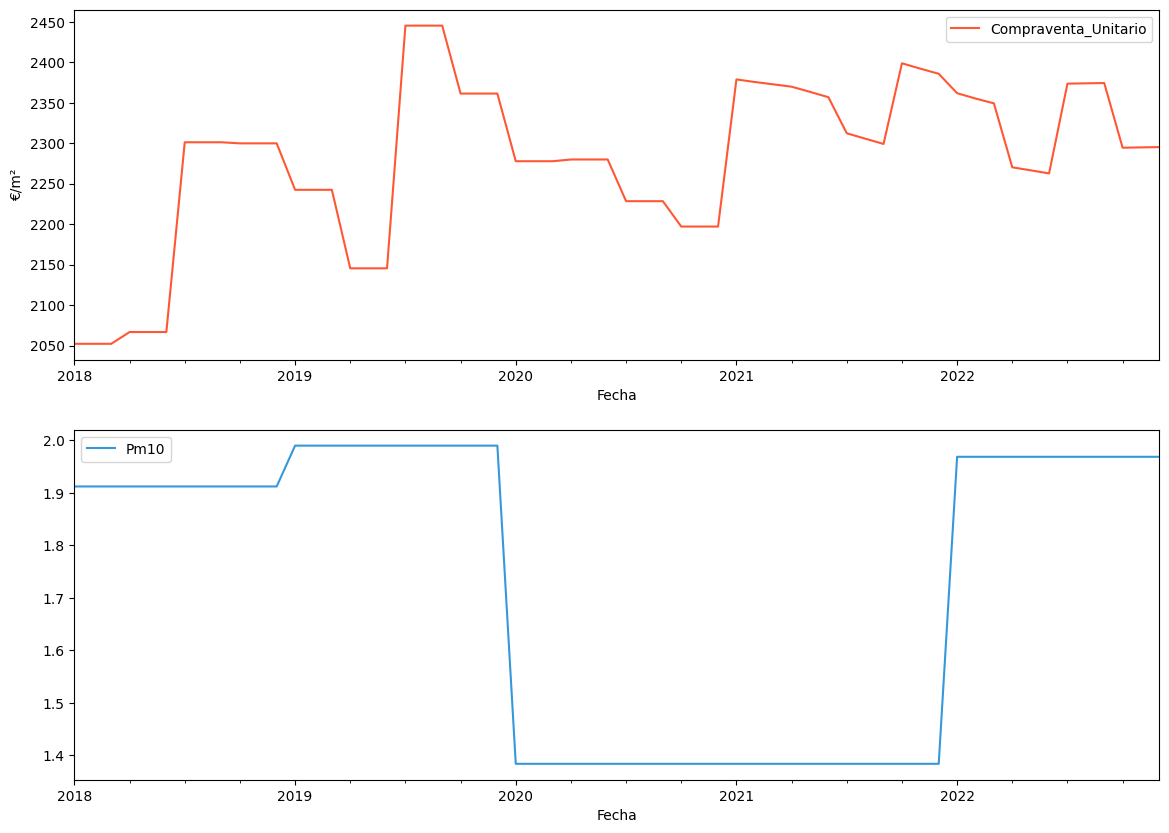

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', '']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,Pm10
Compraventa_Unitario,1.000000,-0.131281
Pm10,-0.131281,1.000000


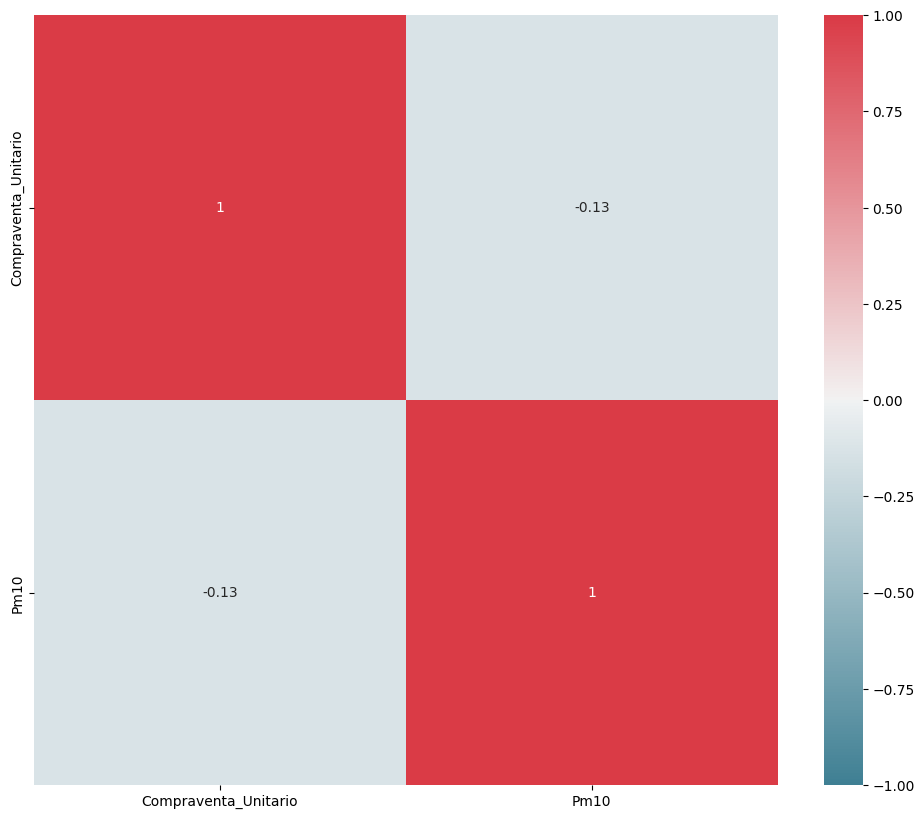

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" y "Pm10" es de -0.131281, lo que sugiere una correlación negativa leve entre estas dos variables en el modelo.

### Dividir los datos en conjunto de Entrenamiento y Prueba

Los modelos siguientes se ajustarán al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



In [53]:
fecha_division = '2022-07-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(54, 2) (6, 2)


####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [54]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [55]:
cointegration_test(X_train[['Compraventa_Unitario', 'Pm10']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  4.87      > 12.3212   =>   False
Pm10   >  0.1       > 4.1296    =>   False


* **Compraventa_Unitario**: No hay suficiente evidencia estadística para rechazar la hipótesis nula de no cointegración. Esto sugiere que "Compraventa_Unitario" no tiene una relación de equilibrio estacionario de largo plazo con las otras series en el sistema.
* **Pm10**: Similarmente, "Pm10" tampoco muestra evidencia de cointegración. No existe una combinación lineal estacionaria que vincule esta serie con otras en el sistema a largo plazo.

Para un análisis conjunto que aún considera las interacciones entre múltiples series no cointegradas, usaremos un modelo VAR (Vector Autoregressive) o VARMA (Vector Autoregressive Moving Average) y descartaremos el modelo VECM (Vector Error Correlation Model), pero primero transformaremos comprobaremos y transformaremos por diferenciacion las veces necesrarias para convertir las series en estacionarias

#### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [56]:
import statsmodels.tsa.stattools as sts

In [57]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.183388
Serie de tiempo Pm10
p-value: 0.569444


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [58]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Pm10
Fecha,,
2018-02-01,0.000000,0.0
2018-03-01,0.000000,0.0
2018-04-01,14.546154,0.0
2018-05-01,0.000000,0.0
2018-06-01,0.000000,0.0


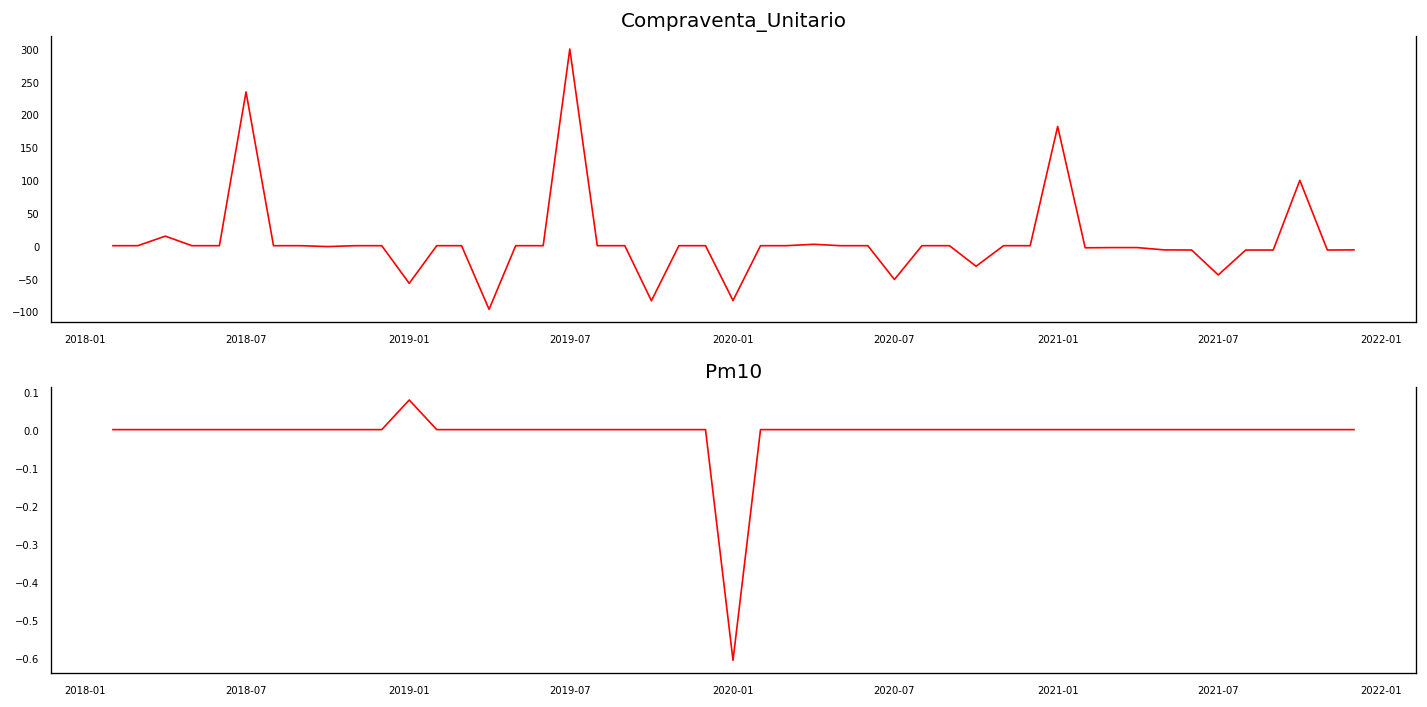

In [23]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [59]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000016
Serie de tiempo transformada Variable Pm10
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




In [60]:
from statsmodels.tsa.api import VAR

In [61]:
model = VAR(X_train_transformed)

#### Seleccionando el orden del modelo

In [62]:
modelsel=model.select_order(8)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,4.187*,4.268*,65.85*,4.217*
1,4.365,4.606,78.67,4.455
2,4.542,4.944,94.09,4.692
3,4.527,5.089,92.96,4.737
4,4.705,5.427,111.7,4.974
5,4.882,5.765,134.6,5.211
6,4.526,5.570,95.56,4.915
7,4.697,5.902,115.6,5.146
8,4.867,6.232,140.5,5.376


Basado en todos estos criterios, el modelo VAR de orden 0 sería el seleccionado. Esto podría sugerir que las variables no presentan dependencias significativas de sus propios valores pasados o entre sí a intervalos de tiempo anteriores. Sin embargo, este resultado es inusual por lo que se probara con otro select_order. Este resultado tampoco es extraño, dada que la longitud de las series temporales es muy reducida.

In [63]:
modelsel=model.select_order(13)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,4.404,4.488*,81.75*,4.434*
1,4.603,4.857,99.88,4.695
2,4.803,5.225,122.2,4.956
3,4.739,5.330,115.2,4.953
4,4.939,5.699,141.8,5.214
5,5.138,6.067,175.5,5.474
6,4.538,5.635,98.14,4.934
7,4.729,5.996,122.3,5.187
8,4.920,6.356,153.8,5.439
9,4.753,6.357,136.8,5.333


#### Ajustando el modelo

In [64]:
res = model.fit(maxlags=12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, May, 2024
Time:                     11:16:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    6.35027
Nobs:                     41.0000    HQIC:                   5.02151
Log likelihood:          -153.694    FPE:                    105.178
AIC:                      4.26054    Det(Omega_mle):         40.5885
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           12.779372        14.588772            0.876           0.381
L1.Compraventa_Unitario         -0.130596         0.197258           -0.662           0.508
L

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "Pm10" es de -0.404490, lo que sugiere una correlación negativa moderada entre los residuos de estas dos variables en el modelo.

In [65]:
res.is_stable()

True

In [66]:
X_train.columns

Index(['Compraventa_Unitario', 'Pm10'], dtype='object')

###### Causalidad de Granger

In [67]:
grangercaus=res.test_causality(['Pm10'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.706,2.070,0.112,"(12, 32)"


In [68]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Pm10'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.396,2.070,0.024,"(12, 32)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [69]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=12
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Pm10_x
Compraventa_Unitario_y,1.0,0.0
Pm10_y,0.0,1.0


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

#### Diagnosis del modelo


###### Residuos

In [70]:
residuals=res.resid

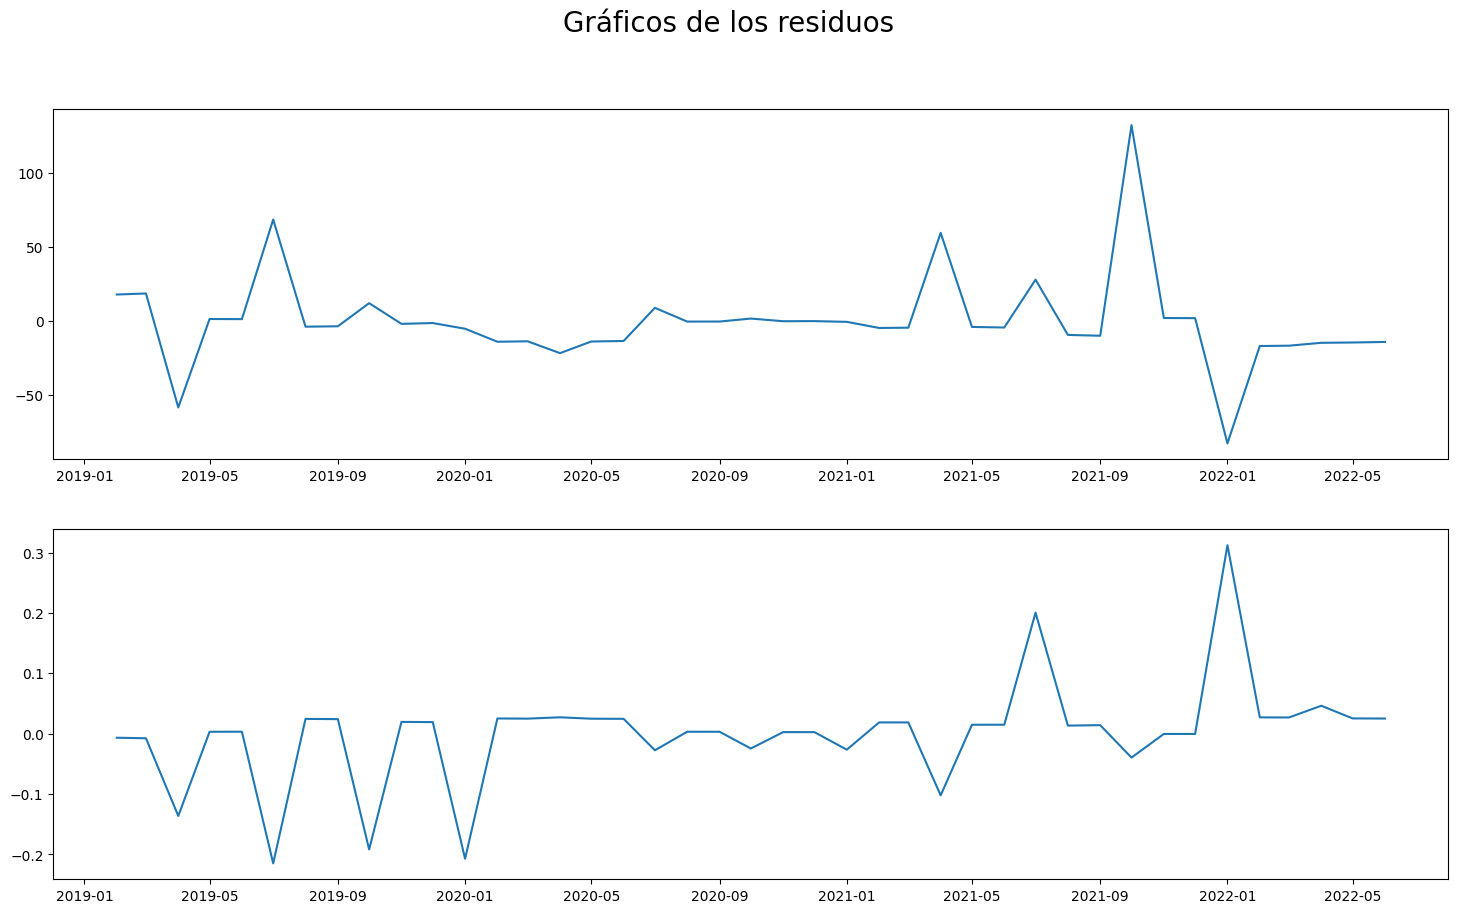

In [71]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [72]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[8.331233046713635e-08, 0.8460892684228332]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


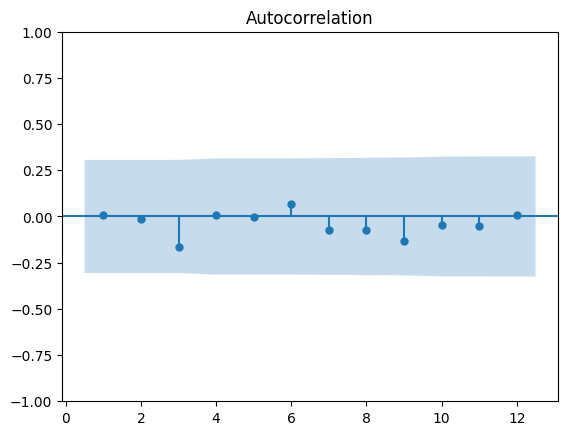

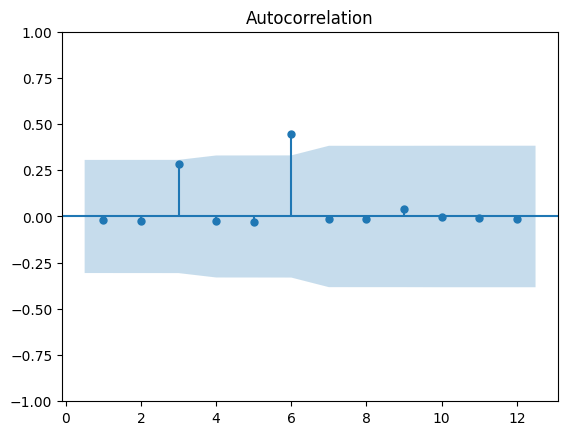

In [73]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 11, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

El punto en el rezago 6 que sale del intervalo de confianza indica una autocorrelación significativa. Este es un hallazgo importante que puede sugerir varias cosas:
- Subespecificación del Modelo: Es posible que el modelo necesite más rezagos para capturar adecuadamente la dinámica subyacente de las series temporales, especialmente si hay una periodicidad o estacionalidad no capturada por el modelo actual.
- Estructura Estacional: Si el modelo no incluyó términos para manejar la estacionalidad y los datos son estacionales (como datos mensuales con patrones anuales), esto podría explicar por qué se detecta autocorrelación a este rezago.




In [74]:
res = model.fit(6)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, May, 2024
Time:                     11:18:07
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    5.41360
Nobs:                     47.0000    HQIC:                   4.77526
Log likelihood:          -210.548    FPE:                    83.0715
AIC:                      4.39012    Det(Omega_mle):         50.9736
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           6.891644         8.856301            0.778           0.436
L1.Compraventa_Unitario        -0.012881         0.127815           -0.101           0.920
L1.Pm

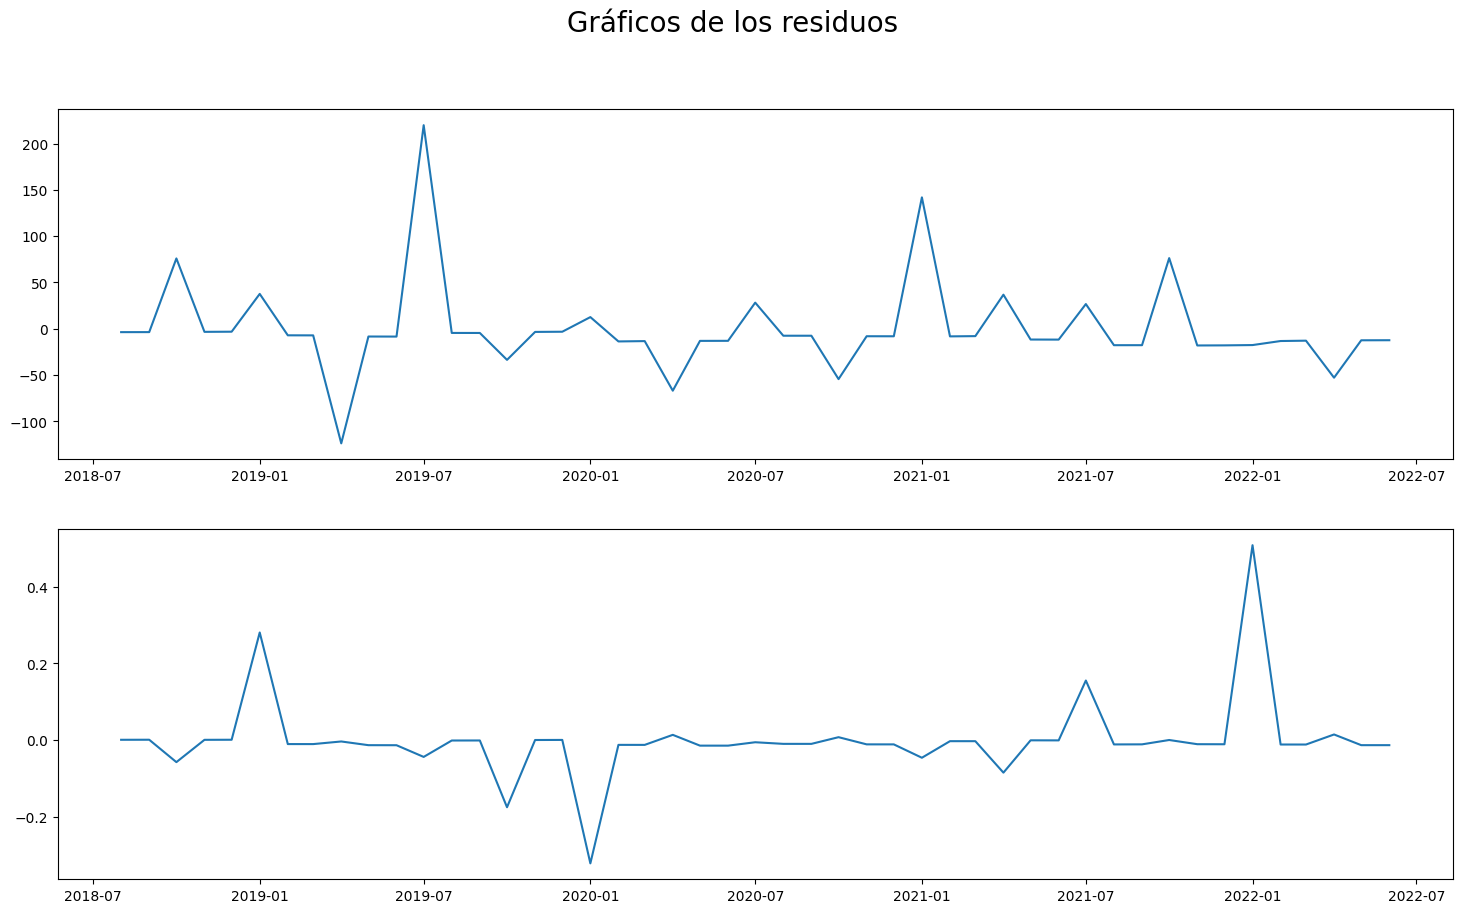

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Graficar la autocorrelación de los residuos del nuevo modelo
resid = res.resid
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(resid.iloc[:,i]) for i in range(2)]
plt.show()

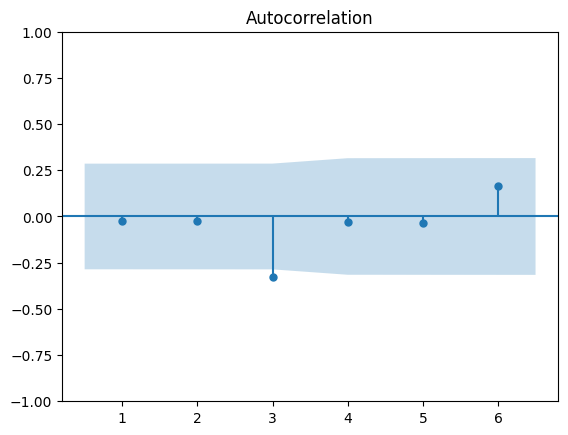

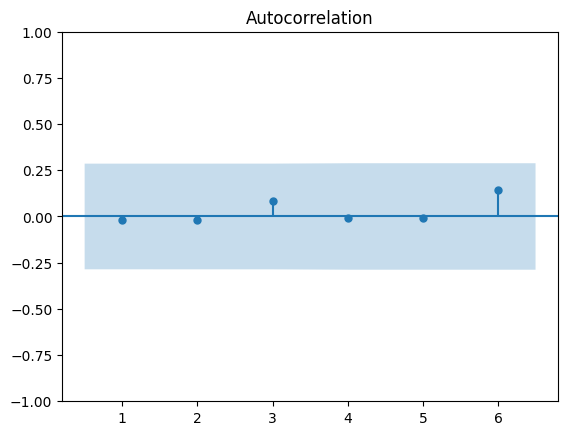

In [76]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(resid.iloc[:,i], zero = False, lags = 6) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 12, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

#### Valores predichos


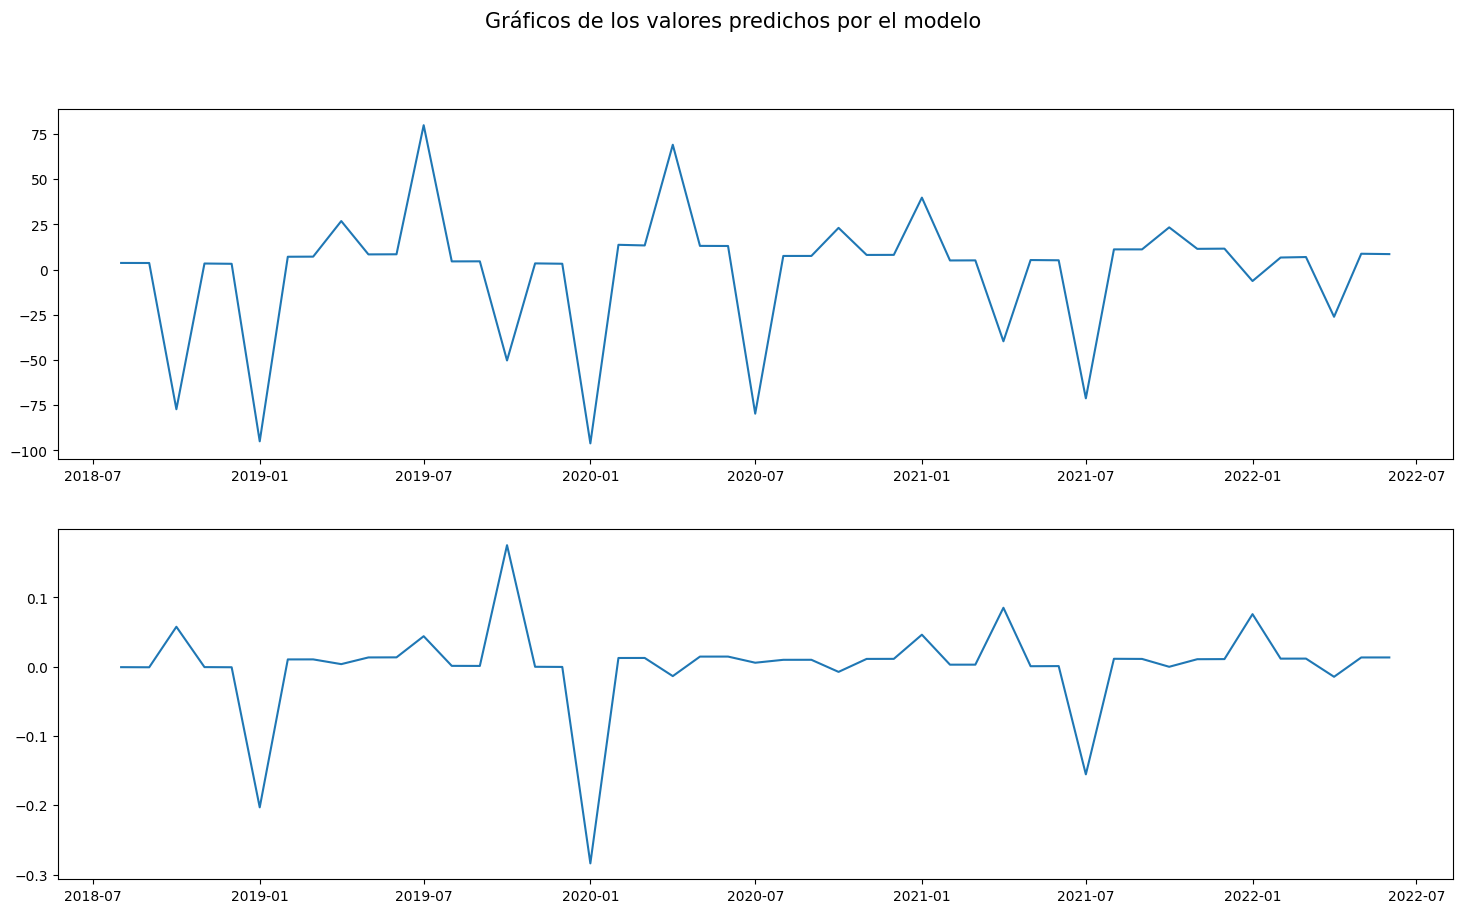

In [77]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [79]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=6)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 6
Predicciones:


,Compraventa_Unitario_pred,Pm10_pred
Fecha,,
2022-07-01,161.986575,0.084786
2022-08-01,9.643825,0.010871
2022-09-01,9.210304,0.009706
2022-10-01,-12.356866,0.132514
2022-11-01,1.254185,0.009452
2022-12-01,1.248261,0.008904


<Figure size 1200x1000 with 0 Axes>

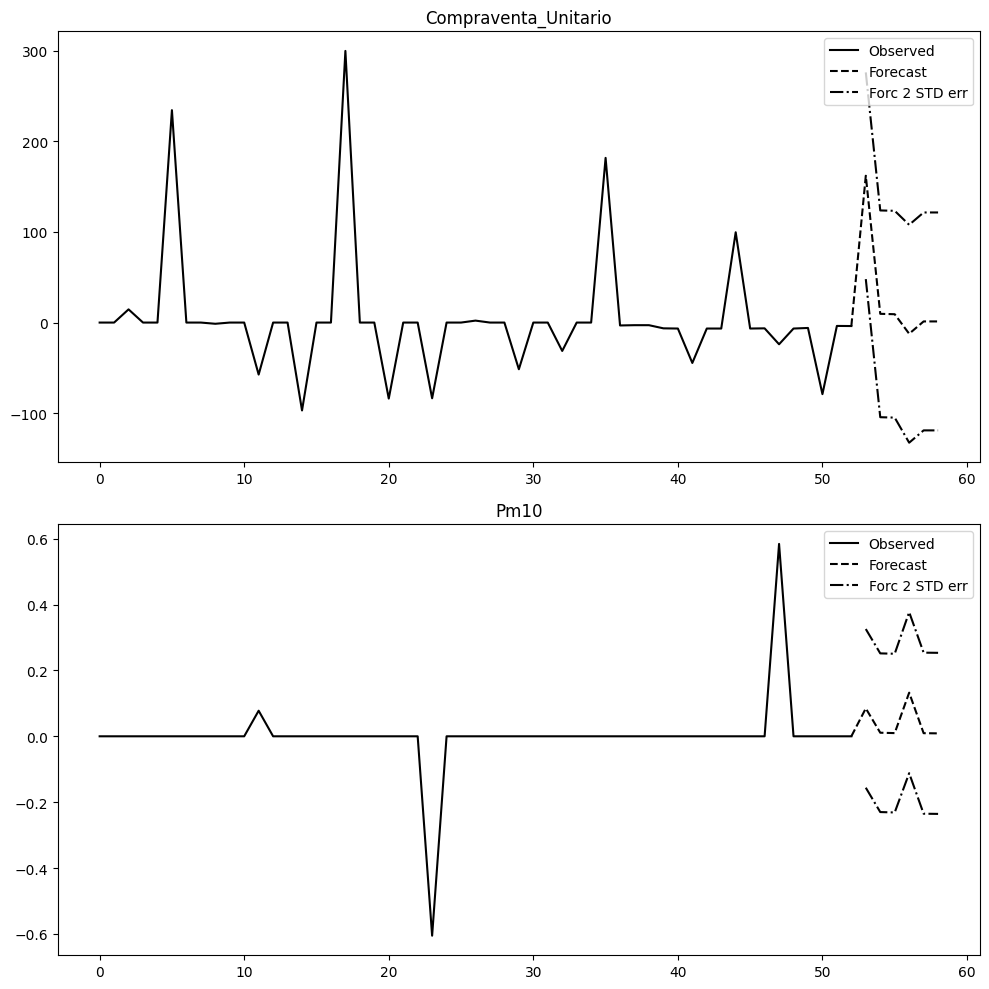

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [81]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [82]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,Pm10
Fecha,,
2022-07-01,2424.683454,2.053261
2022-08-01,2434.327278,2.064132
2022-09-01,2443.537583,2.073838
2022-10-01,2431.180716,2.206351
2022-11-01,2432.434901,2.215803
2022-12-01,2433.683162,2.224707


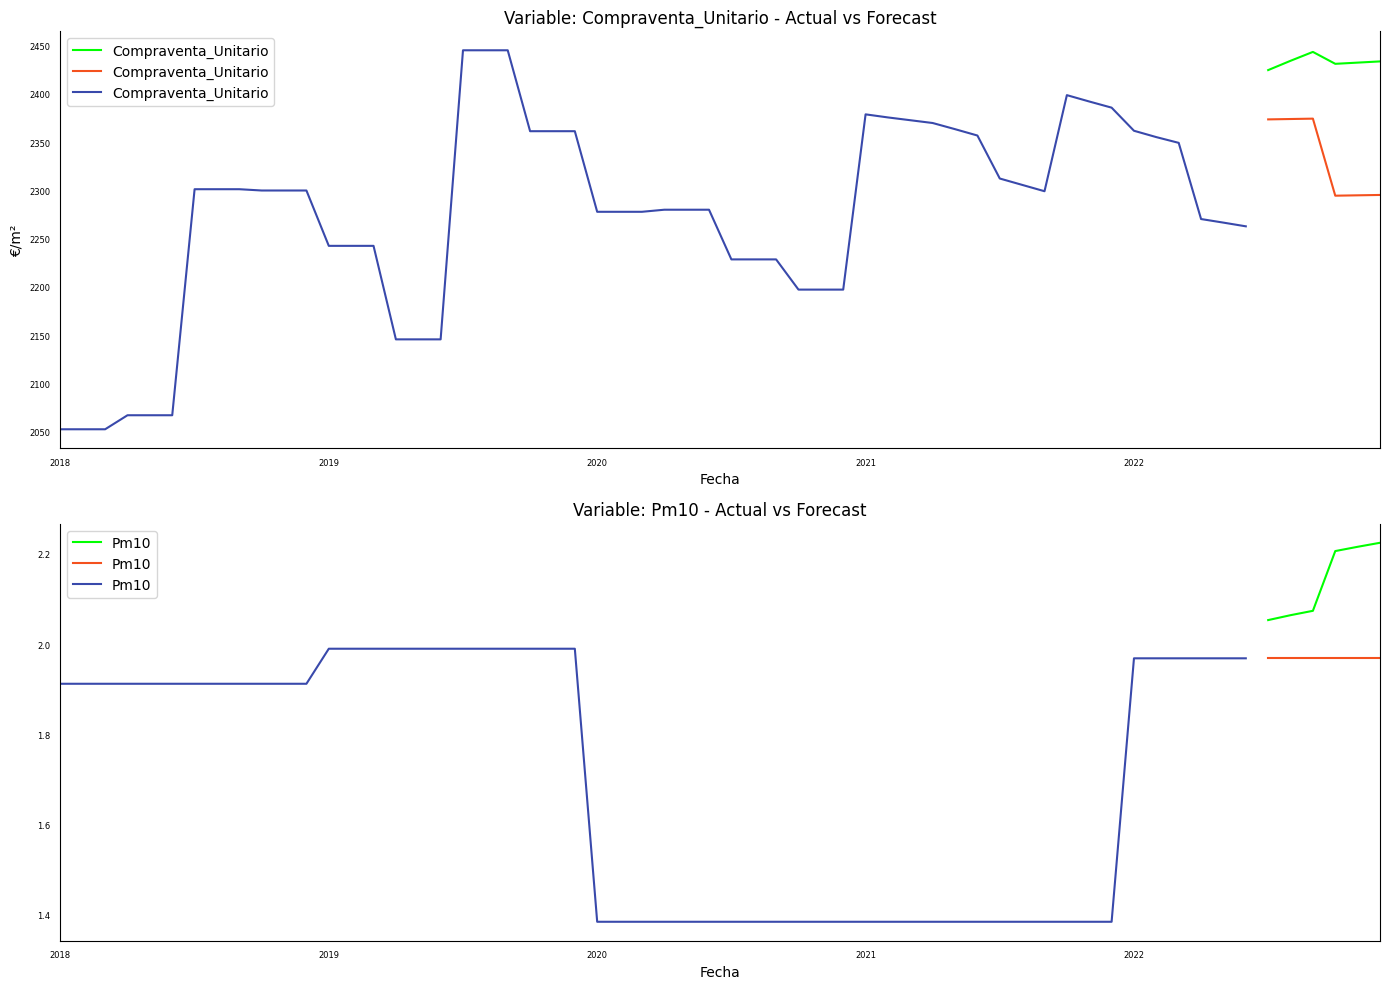

In [83]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [84]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [85]:
for i in ['Compraventa_Unitario','Pm10']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 11306.637506471714
MAE is : 98.90840167620543
RMSE is : 106.33267374834377
MAPE is : 4.266276381772216
R2 is : -6.225487285737438

Evaluation metric for Pm10
Evaluation metric results:-
MSE is : 0.035141849126071656
MAE is : 0.17120691667809326
RMSE is : 0.18746159373608146
MAPE is : 8.697438895676694
R2 is : 0.0



El modelo para Compraventa_Unitario presenta un desempeño muy deficiente, con un R² extremadamente negativo de -6.23 y altos valores de MSE y RMSE, indicando que las predicciones son inadecuadas y menos útiles que usar una simple media. En contraste, el modelo para Pm10 muestra errores cuantitativos bajos en términos de MSE, MAE y RMSE, pero un MAPE del 8.70% y un R² de 0.0 revelan que, aunque los errores absolutos son bajos, proporcionalmente son significativos y el modelo no mejora las predicciones sobre un modelo basado en la media.

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 49.53980429644176
Root mean squared error: 75.1886715147995


### Modelo VARMA (Auto Arima)

El modelo VARMA (Vector Autoregressive Moving Average) es una técnica estadística utilizada en análisis de series temporales que combina los modelos VAR (Vector Autoregressive) y MA (Moving Average). Es especialmente útil cuando se trata de series temporales múltiples, permitiendo modelar la interdependencia entre varias series a lo largo del tiempo junto con términos de error autocorrelacionados.



In [87]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.7 MB/s eta 0:00:00


#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [88]:
import pmdarima as pm

In [89]:

pq = []
for name in ['Compraventa_Unitario', 'Pm10']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=595.722, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=597.722, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=597.722, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=599.722, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=597.527, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.379 seconds
optimal order for:Compraventa_Unitario is: (0, 0, 0) 


Searching order of p and q for : Pm10
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-75.859, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-73.859, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-73.859, Time=0.81 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-71.859, Time=1.81 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-73.864, Time=0.51 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]   

In [90]:
pq

[(0, 0, 0), (0, 0, 0)]

#####Seleccion del modelo


- *p=0:* Indica que no hay términos autoregresivos en el modelo. En otras palabras, el modelo VARMAX no incluye dependencia de los valores pasados de las variables en sí mismas.

- *q=0:* Indica que no hay términos de medias móviles en el modelo. Esto significa que no hay dependencia de los errores pasados del modelo en sí mismo.

En este caso no se puede aplicar el modelo VARMAX, ya que el modelo esta considerando unicamente la tendencia lineal y no esta incorporando autocorrelacion en los residuos del modelo.

##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_Unitario y concentracion de particulas Pm 10 tenemos que:

- Se ha comprobado que las variables no tienen correlacion.
- Se ha realizado el test de Cointegracion y se ha demostrado que las series no estan cointegradas, lo que desestima la opcion de aplicar un modelo VECM
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad, con un orden de 1 diferenciacion, lo que las hace aptas para aplicar los dos modelos VAR y VARMA.
- Modelo VAR: Las metricas de evaluacion del modelo VAR, son bastante cuestionables para las dos series temporales. Esto es debido a la poca cantidad de datos.
- No se a podido aplicar el modelo VARMA, por la nula dependencia de los valores pasados de las variables en si mismas. Esto es debido principalmente a los pocos datos que contienen estas dos series temporales.

Con los datos obtenidos unicamente se ha podido entrenar un modelo VAR y no es nada concluyente.

